In [1]:
import os
import random
import numpy as np
import pandas as pd
import multiprocessing
import tensorflow as tf
import keras
from scipy import signal
from itertools import starmap
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from model_src.Resnet import ResNet34
from model_src.Unet import Unet
from model_src.DilatedConv import RespDNN
from model_src.BianResnet import ResNet
import matplotlib.pyplot as plt
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
DATA_PATH = '../../DataLake/stMary'
kf = KFold(n_splits=5)

2023-06-05 11:22:08.727488: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 11:22:08.773759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 11:22:09.424027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def generate_dataset(arg_pleths, arg_resps, fs=125, shift_factor=4):
    import copy
    dataset = []
    window_size = fs * 60 # 7500
    shift = int(window_size/shift_factor)
    samples_len = len(arg_pleths)

    cpy_resps = copy.deepcopy(arg_resps)
    cpy_pleths = copy.deepcopy(arg_pleths)

    for j in range(samples_len):
        rr = cpy_resps[j]; ppg = cpy_pleths[j]

        rr['offset'] = (rr['offset']-rr['offset'].min())/1000
        size_lim = int(fs * np.ceil(rr['offset'].max()))
        ppg = ppg[:size_lim]
        shift_n_times = int((len(ppg)-window_size)/shift)+1

        samp_rr = [len(rr.loc[ (rr['offset']>=0+(int(shift/fs)*i)) & ((rr['offset']<int(window_size/fs)+(int(shift/fs)*i))) ]) for i in range(shift_n_times)]
        samp_ppg = [ppg[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]

        for i in range(len(samp_ppg)):
            temp = []
            temp.append(samp_ppg[i])
            temp.append(samp_rr[i])
            dataset.append(temp)

    return dataset


def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.asarray(output_signal)


def preprocessing(targets=None):
    print('Extract PLETH/RESP')
    pleths = [pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values for sid in targets.id.unique()]
    resps = [pd.read_csv(f'{DATA_PATH}/{sid}/respirationTimeline.csv', header=None, names=['sid', 'offset']) for sid in targets.id.unique()]

    # Before filtering: Check NaN
    for pleth in pleths:
        if any(np.isnan(pleth)):
            print('check')

    # Before filtering: Convert type as np.int16
    pleths = list(map(lambda pleth: pleth.astype(np.float32), pleths))


    print('Init Preprocessing: Filtering')
    taps = signal.firwin(numtaps=400, cutoff=[0.5, 8.0], window='hamming', pass_zero=False, fs=125)
    w, h = signal.freqz(taps)
    pool = multiprocessing.Pool(processes=40)
    filtered_pleths = pool.starmap(signal.filtfilt, [(taps, 1.0, pleth) for pleth in pleths])
    pool.close()
    pool.join()


    print('Init Preprocessing: Windowing')
    dataset = generate_dataset(filtered_pleths, resps, shift_factor=60)


    print('Init Preprocessing: Resampling')
    pool = multiprocessing.Pool(processes=40)
    result = pool.starmap(signal_resample, [(pleth[0], 125, 30) for pleth in dataset])
    pool.close()
    pool.join()

    new_patient = []
    for i in range(len(dataset)):
        temp = []
        temp.append(result[i])
        temp.append(dataset[i][1])
        new_patient.append(temp)

    return new_patient


def prepare_modeling(dataset=None, batchsize=None):
    print(f'Prepare modeling')
    pleths = []
    resps = []
    for ppg, rr in dataset:
        pleths.append(ppg.astype(np.float32))
        resps.append(rr)
    pleths = np.asarray(pleths)
    resps = np.asarray(resps)
    print(pleths.shape, resps.shape)

    scaler = MinMaxScaler()
    scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
    print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

    x, y = scaled_pleths[:], resps[:]

    return tf.data.Dataset.from_tensor_slices((x, y)).batch(batchsize)

### Train-Val-Test Split

In [4]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
patients = subjects.loc[subjects['diagnosis']!='0']

print('Init Sampling')
rand_idx = list(range(100))
random.seed(42)
test_idx = random.sample(rand_idx, k=20)
train_idx = list(set(rand_idx) - set(test_idx))
train_patients = patients.iloc[train_idx]
test_patients = patients.iloc[test_idx]
print('Train-Test Split into 80:20 (Random seed 42)')
print(train_idx, test_idx)

Init Sampling
Train-Test Split into 80:20 (Random seed 42)
[0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 70, 72, 73, 74, 76, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99] [81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11, 75, 54, 4, 27, 29, 64, 77, 71]


### Train-Val Split

In [3]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
patients = subjects.loc[subjects['diagnosis']!='0']
train_patients = patients.sample(frac=1, random_state=42)
# display(patients.head())
# display(train_patients.head())

In [48]:
EPOCHS = 1000
BATCH_SIZE = 256
LR = 0.001
callbacks = [
    EarlyStopping(monitor='val_loss', patience=33),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
]

In [44]:
counter = 1
raw_dataset = {
    'train': [],
    'val': []
}
dataset = {
    'train': [],
    'val': []
}
for train_idx, val_idx in kf.split(train_patients):
    print(f'{counter}th K-fold')
    counter = counter + 1
    # 이렇게 하는 이유는 Train과 Validation을 완벽히 구별시키기 위함이다.
    X_train = preprocessing(train_patients.iloc[train_idx])
    X_val = preprocessing(train_patients.iloc[val_idx])
    print(f'Preprocessing finished: {len(X_train)} / {len(X_val)}')

    raw_dataset['train'].append(X_train)
    raw_dataset['val'].append(X_val)
    
    train_dataset = prepare_modeling(X_train, batchsize=256)
    val_dataset = prepare_modeling(X_val, batchsize=256)

    dataset['train'].append(train_dataset)
    dataset['val'].append(val_dataset)

1th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5180 / 1328
Prepare modeling
(5180, 1800) (5180,)
(5180, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1328, 1800) (1328,)
(1328, 1800, 1) <class 'numpy.float32'>
2th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5214 / 1294
Prepare modeling
(5214, 1800) (5214,)
(5214, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1294, 1800) (1294,)
(1294, 1800, 1) <class 'numpy.float32'>
3th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preproces

In [53]:
import os
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Dense, BatchNormalization, Activation, Add, Flatten, Dropout, Multiply
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')

class RespBlock(Model):
    def __init__(self, filters, *args, **kwargs):
        super(RespBlock, self).__init__(*args, **kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=1, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=2, padding='same')
        self.bn2 = BatchNormalization()

        self.conv3 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=3, padding='same')
        self.bn3 = BatchNormalization()

        # self.conv4 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=5, padding='same')
        # self.bn4 = BatchNormalization()

        self.conv1x1 = Conv1D(filters=filters*2, kernel_size=1, strides=1, padding='same')
        self.bn1x1 = BatchNormalization()


    def call(self, inputs, training=None, mask=None):
        x1 = self.conv1(inputs)
        x1 = self.bn1(x1)
        x1 = Activation('relu')(x1)

        x2 = self.conv2(inputs)
        x2 = self.bn2(x2)
        x2 = Activation('relu')(x2)
        
        x3 = self.conv3(inputs)
        x3 = self.bn3(x3)
        x3 = Activation('relu')(x3)

        # x4 = self.conv4(inputs)
        # x4 = self.bn4(x4)
        # x4 = Activation('relu')(x4)

        x = Add()([x1, x2, x3])
        x = Activation('relu')(x)
        
        x = self.conv1x1(x)
        x = self.bn1x1(x)

        if inputs.shape[-1] != 1:
            inputs = tf.reduce_mean(inputs, axis=-1, keepdims=True)
           
        x = Add()([x, inputs])
        return Activation('relu')(x)


class RespDNN2(Model):
    def __init__(self, *args, **kwargs):
        super(RespDNN2, self).__init__(*args, **kwargs)
        self.respblk = [RespBlock(32*i) for i in np.arange(1, 4)]
        self.dwnsamp = [Conv1D(32*i, kernel_size=3, strides=2, padding='same') for i in np.arange(1, 4)]
        self.bn = [BatchNormalization() for _ in range(3)]
        self.avgpool = AveragePooling1D(strides=2, padding='valid')
        self.dense1 = Dense(1000, activation='relu')
        self.dense2 = Dense(100, activation='relu')
        self.dense3 = Dense(1)

    @tf.function
    def call(self, inputs, training=None, mask=None):
        x = inputs

        for i in range(3):
            x = self.respblk[i](x)
            x = self.dwnsamp[i](x)
            x = self.bn[i](x)
            x = Activation('relu')(x)

        x = self.avgpool(x)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
train_losses = []
val_losses = []
for i in range(5):
    print(f'{i+1}th K-fold')
    # model = ResNet34()
    # model = ResNet()
    # model = Unet()
    model = RespDNN2()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=keras.metrics.MeanAbsoluteError()
    )  

    # callbacks.append(ModelCheckpoint(f'../models/230531-Resnet-L34-stmary-KF{i}', monitor='val_loss', save_best_only=True))
    
    history = model.fit(
        dataset['train'][i],
        epochs=EPOCHS,
        callbacks=callbacks,
        validation_data=dataset['val'][i]
    )

    train_losses.append(min(history.history['loss']))
    val_losses.append(min(history.history['val_loss']))

1th K-fold
Epoch 1/1000


2023-06-05 20:09:32.180248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND/block_shape' with dtype int32 and shape [1]
	 [[{{node gradients/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND/block_shape}}]]
2023-06-05 20:09:32.180366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_127/conv1d_647/Conv1D/BatchToSpaceND/crops' with dtype int32 a

21/21 [==============================] - 15s 213ms/step - loss: 9.2261 - mean_absolute_error: 9.2261 - val_loss: 17.0575 - val_mean_absolute_error: 17.0575 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 4s 187ms/step - loss: 5.5137 - mean_absolute_error: 5.5137 - val_loss: 13.3929 - val_mean_absolute_error: 13.3929 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 4s 186ms/step - loss: 4.7514 - mean_absolute_error: 4.7514 - val_loss: 8.6561 - val_mean_absolute_error: 8.6561 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 4s 187ms/step - loss: 4.3245 - mean_absolute_error: 4.3245 - val_loss: 10.0821 - val_mean_absolute_error: 10.0821 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 4s 187ms/step - loss: 4.7022 - mean_absolute_error: 4.7022 - val_loss: 6.8211 - val_mean_absolute_error: 6.8211 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 4s 187ms/step - loss: 3.9021 - mean_absolute_error: 3.902

2023-06-05 20:14:13.154194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND/block_shape' with dtype int32 and shape [1]
	 [[{{node gradients/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND/block_shape}}]]
2023-06-05 20:14:13.154327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND_grad/SpaceToBatchND/resp_block_130/conv1d_662/Conv1D/BatchToSpaceND/crops' with dtype int32 a

In [51]:
train_losses = np.asarray(train_losses)
print(f'{np.mean(train_losses)} ± {np.std(train_losses)}')

0.8781261205673218 ± 0.3424874897517857


In [52]:
val_losses = np.asarray(val_losses)
print(f'{np.mean(val_losses)} ± {np.std(val_losses)}')

3.3662635326385497 ± 0.4852466212526413


In [ ]:
X_test = preprocessing(test_patients)
print(f'Preprocessing finished: {len(X_test)}')

test_dataset = prepare_modeling(X_test, batchsize=BATCH_SIZE)

for i in range(5):
    print(f'call model {i}')

---

In [31]:
len(raw_dataset['val'][3])

1074

/tmp/ipykernel_275413/2948758707.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=linewidths[i], alpha=alphas[i], label=f'kfold-{i+1}')


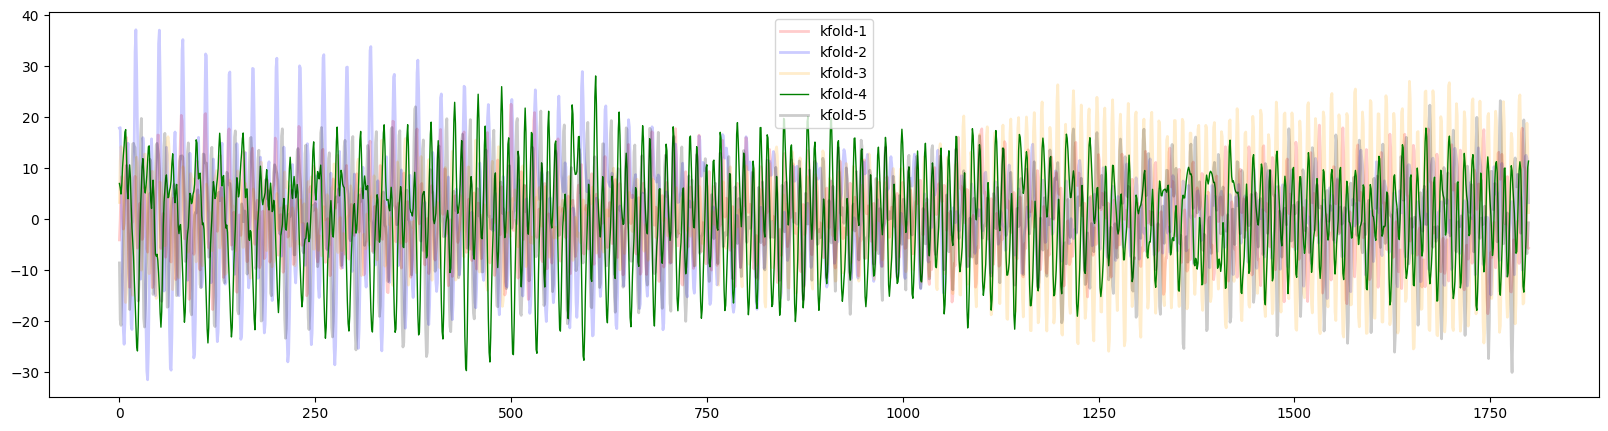

In [38]:
# raw_dataset = {'train', 'val'}
colors = ['red', 'blue', 'orange', 'green', 'black']
alphas = [.2, .2, .2, 1, .2]
linewidths = [2, 2, 2, 1, 2]
plt.figure(figsize=(20,5))

for i, val in enumerate(raw_dataset['val']):
    plt.plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=linewidths[i], alpha=alphas[i], label=f'kfold-{i+1}')

plt.legend()
plt.show()

/tmp/ipykernel_275413/3762171299.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  axs[i].plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=2, alpha=alphas[i], label=f'kfold-{i+1}')


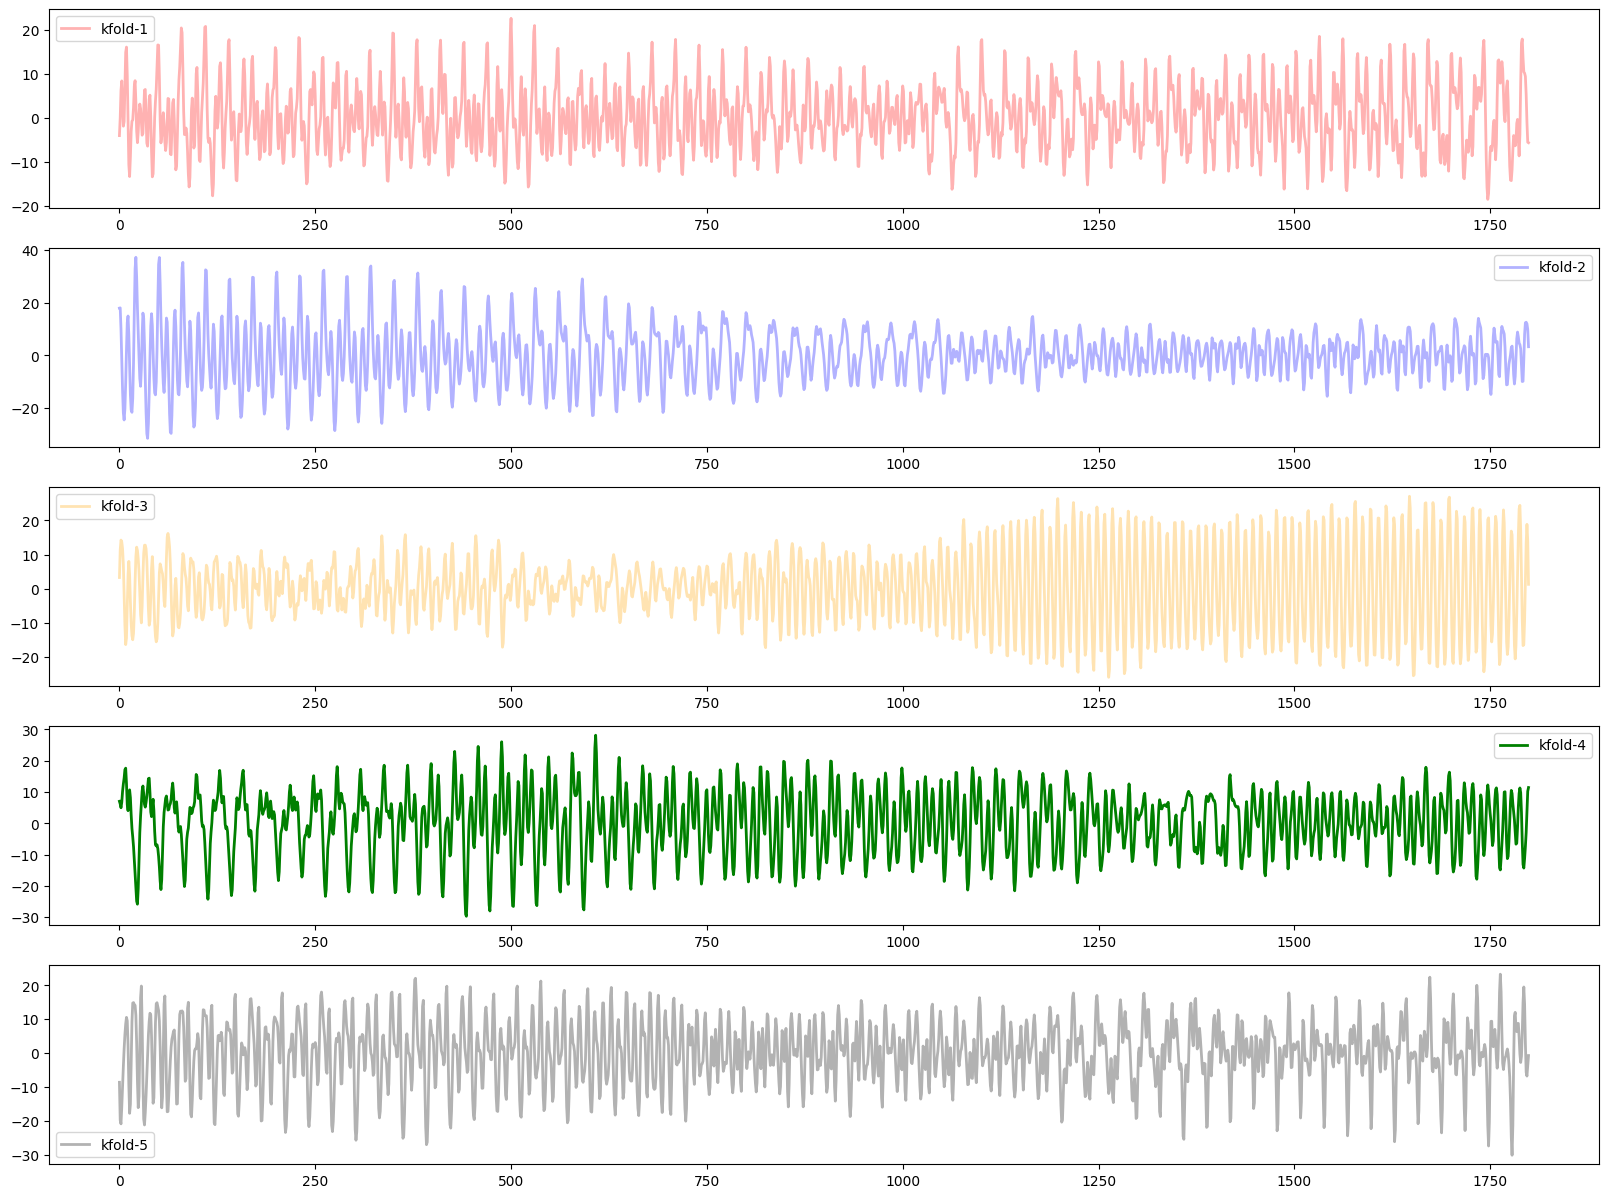

In [39]:
# raw_dataset = {'train', 'val'}
colors = ['red', 'blue', 'orange', 'green', 'black']
alphas = [.3, .3, .3, 1, .3]
fig, axs = plt.subplots(5,1,figsize=(20,15))

for i, val in enumerate(raw_dataset['val']):
    axs[i].plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=2, alpha=alphas[i], label=f'kfold-{i+1}')
    axs[i].legend()

plt.show()